# Project: Give Me Some Credit

This project is a binary classification task aimed at predicting whether a person has experienced 90 days or more of past-due delinquency. The dataset includes financial and demographic features. Using a variety of classification algorithms and evaluation metrics, it aims to identify the most effective approach for predicting credit default events. The notebook includes data preprocessing, missing value handling, model training, performance evaluation, and visualization.
The related dataset can be found here: https://www.kaggle.com/c/GiveMeSomeCredit/data

## Data overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
#pip install xgboost

In [2]:
random_seed = 0
np.random.seed(random_seed)

## Preprocessing

In [3]:
data = pd.read_csv('GiveMeSomeCredit-training.csv')
df = data.copy()
df.shape

(150000, 12)

## details about target variable

In [4]:
N = df.shape[0]
number = sum(df['SeriousDlqin2yrs'] == 1)

print(f"Total number of clients: {N}")
print(f"Number of clients experienced 90 days past due delinquency or worse: {number} ({number/N*100:.2} % of the total)")

Total number of clients: 150000
Number of clients experienced 90 days past due delinquency or worse: 10026 (6.7 % of the total)


## checking missing value 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [6]:
# Filter data for non-missing 'MonthlyIncome' and compute the mean income by delinquency status(0 = no, 1 = yes)
Income_nonnull = df[df['MonthlyIncome'].notnull()]
print(Income_nonnull.groupby('SeriousDlqin2yrs')['MonthlyIncome'].mean())

SeriousDlqin2yrs
0    6747.837774
1    5630.826493
Name: MonthlyIncome, dtype: float64


In [7]:
print('Mean monthly income of all clients:', df['MonthlyIncome'].mean())
print('Median monthly income of all clients:', df['MonthlyIncome'].median())
print('Maximum monthly income of all clients:', df['MonthlyIncome'].max())
print('Minimum monthly income of all clients:', df['MonthlyIncome'].min())

Mean monthly income of all clients: 6670.221237392844
Median monthly income of all clients: 5400.0
Maximum monthly income of all clients: 3008750.0
Minimum monthly income of all clients: 0.0


In [8]:
# Compare average number of dependents by delinquency status (0 = no, 1 = yes), using non-missing data only
Dependent_nonnull = df[df['NumberOfDependents'].notnull()]
print(Dependent_nonnull.groupby('SeriousDlqin2yrs')['NumberOfDependents'].mean())

SeriousDlqin2yrs
0    0.743417
1    0.948208
Name: NumberOfDependents, dtype: float64


In [9]:
print('Mean number of dependents for all clients:', df['NumberOfDependents'].mean())
print('Median number of dependents for all clients:', df['NumberOfDependents'].median())
print('Maximum number of dependents for all clients:', df['NumberOfDependents'].max())
print('Minimum number of dependents for all clients:', df['NumberOfDependents'].min())

Mean number of dependents for all clients: 0.7572222678605657
Median number of dependents for all clients: 0.0
Maximum number of dependents for all clients: 20.0
Minimum number of dependents for all clients: 0.0


On average, delinquent clients have a lower average monthly income, indicating its importance in predicting default risk. 
Delinquent clients also have more dependents, suggesting that this feature is relevant to default risk.

In [10]:
# Mark missing income as 1, others as 0
df['Income_dummy'] = df['MonthlyIncome'].isnull().astype(int)

# Fill missing income with median (more robust to outliers)
df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].median())
df['NumberOfDependents'] = df['NumberOfDependents'].fillna(df['NumberOfDependents'].median())

## checking correlation between features

In [11]:
# Drop unnecessary index column
df = df.drop('Unnamed: 0', axis=1)

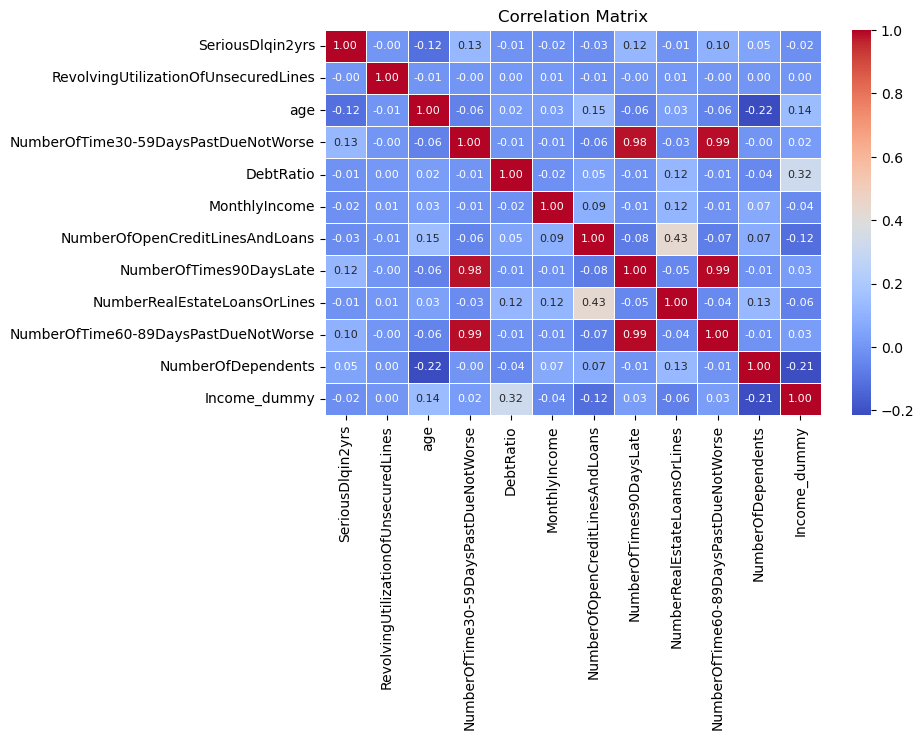

In [12]:
plt.figure(figsize=(8, 5))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8}, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## What is the distribution of the features? 

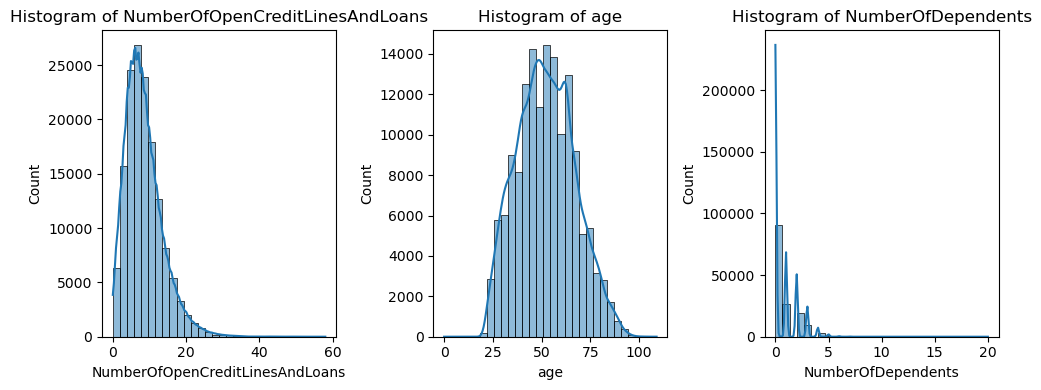

In [13]:
continuous_feature = ['NumberOfOpenCreditLinesAndLoans', 'age', 'NumberOfDependents']
plt.figure(figsize=(10, 4))  

for i, col in enumerate(continuous_feature, 1):
    plt.subplot(1, 3, i)  
    sns.histplot(df[col], kde=True, bins=30)  # Plot histogram with KDE
    plt.title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

## Are there any outliers?

In [14]:
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Income_dummy
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.418455e+03,8.452760,0.265973,1.018240,0.240387,0.737413,0.198207
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.289040e+04,5.145951,4.169304,1.129771,4.155179,1.107021,0.398650
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.903000e+03,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000,0.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000,1.000000


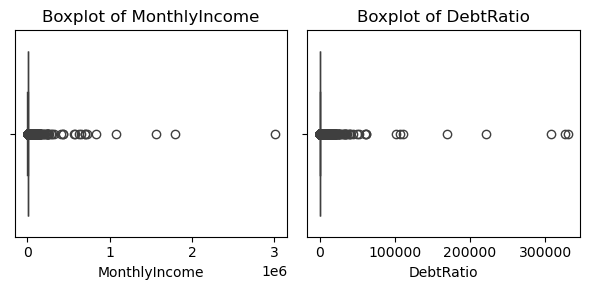

In [15]:
# Select columns to check for outliers
outlier = ['MonthlyIncome', 'DebtRatio']

plt.figure(figsize=(6, 3))
for i, col in enumerate(outlier, 1):
    plt.subplot(1, 2, i)  # Create a 1x2 grid of subplots
    sns.boxplot(x=df[col])  # Draw boxplot to visualize outliers
    plt.title(f'Boxplot of {col}')  # Add title
plt.tight_layout()  # Adjust layout
plt.show()  # Display plots

In [16]:
# Check extreme values (e.g., top 1% / bottom 1%)
df['MonthlyIncome'].quantile([0.01, 0.99])

0.01        0.0
0.99    23000.0
Name: MonthlyIncome, dtype: float64

In [17]:
# Get the 99th percentile of MonthlyIncome
income_99th_percentile = df['MonthlyIncome'].quantile(0.99)
debt_99th_percentile = df['DebtRatio'].quantile(0.99)

# Count the number of extreme large values (greater than 99th percentile)
extreme_values_count = (df['MonthlyIncome'] > income_99th_percentile).sum()
print(f"Number of extreme large values: {extreme_values_count}")

# View the extreme large values
extreme_values = df[df['MonthlyIncome'] > income_99th_percentile]
print(extreme_values[['MonthlyIncome']])

Number of extreme large values: 1499
        MonthlyIncome
4             63588.0
9             23684.0
266          208333.0
274           26484.0
334           25000.0
...               ...
149481        51140.0
149705        25000.0
149839        37500.0
149893        25833.0
149944        24000.0

[1499 rows x 1 columns]


In [18]:
# Replace extreme large values with the 99th percentile value
df['MonthlyIncome'] = df['MonthlyIncome'].apply(lambda x: income_99th_percentile if x > income_99th_percentile else x)
df['DebtRatio'] = df['DebtRatio'].apply(lambda x: debt_99th_percentile if x > debt_99th_percentile else x)

# Train-test-split

In [19]:
X = df.drop('SeriousDlqin2yrs', axis=1)
y = df['SeriousDlqin2yrs']

In [20]:
# Use stratify=y to maintain the original class distribution in both training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [21]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting models

In [22]:
# Initialize models with class weight balanced to address class imbalance
log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, class_weight='balanced', C=100, penalty='l2', random_state=42)
rf_clf = RandomForestClassifier(n_estimators=400, max_depth=10, class_weight='balanced', min_samples_split=5, random_state=42)

# Calculate scale_pos_weight = negative / positive
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_clf = XGBClassifier(scale_pos_weight=scale_pos_weight, max_depth=5, learning_rate=0.05, n_estimators=300, subsample=0.8,
                        colsample_bytree=0.8, eval_metric='logloss', random_state=42)

# 'soft' voting uses predicted probabilities
voting_clf = VotingClassifier(estimators=[('log', log_clf), ('rf', rf_clf), ('xgb', xgb_clf)],voting='soft')  

# Train classifiers
classifiers = [log_clf, rf_clf, xgb_clf, voting_clf]
for clf in classifiers:
    clf.fit(X_train_scaled, y_train)

# Evaluating performance

In [23]:
# Make predictions on the test set
log_pred = log_clf.predict(X_test_scaled)
rf_pred = rf_clf.predict(X_test_scaled)
xgb_pred = xgb_clf.predict(X_test_scaled)
voting_pred = voting_clf.predict(X_test_scaled)

In [24]:
# Calculate ROC AUC scores for model evaluation
log_roc_auc = roc_auc_score(y_test, log_clf.predict_proba(X_test_scaled)[:, 1])
rf_roc_auc = roc_auc_score(y_test, rf_clf.predict_proba(X_test_scaled)[:, 1])
xgb_roc_auc = roc_auc_score(y_test, xgb_clf.predict_proba(X_test_scaled)[:, 1])
voting_roc_auc = roc_auc_score(y_test, voting_clf.predict_proba(X_test_scaled)[:, 1])

In [25]:
# Print classification reports and ROC AUC scores for each model
print("Logistic Regression Classification Report:")
print(classification_report(y_test, log_pred))
print(f"Logistic Regression ROC AUC: {log_roc_auc:.4f}")
print("---------------------------------------------------------")

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))
print(f"Random Forest ROC AUC: {rf_roc_auc:.4f}")
print("---------------------------------------------------------")

print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))
print(f"XGBoost ROC AUC: {xgb_roc_auc:.4f}")
print("---------------------------------------------------------")

print("Voting Classification Report:")
print(classification_report(y_test, voting_pred))
print(f"Voting ROC AUC: {voting_roc_auc:.4f}")

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.78      0.86     41992
           1       0.18      0.67      0.28      3008

    accuracy                           0.77     45000
   macro avg       0.57      0.72      0.57     45000
weighted avg       0.92      0.77      0.83     45000

Logistic Regression ROC AUC: 0.8002
---------------------------------------------------------
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     41992
           1       0.23      0.73      0.35      3008

    accuracy                           0.82     45000
   macro avg       0.60      0.78      0.62     45000
weighted avg       0.93      0.82      0.86     45000

Random Forest ROC AUC: 0.8607
---------------------------------------------------------
XGBoost Classification Report:
              precision    recall  f1-score   support

## Comparing accuracy

In [26]:
accuracy_dict = {'Logistic Regression': accuracy_score(y_test, log_pred),
    'Random Forest': accuracy_score(y_test, rf_pred),
    'XGB': accuracy_score(y_test, xgb_pred),
    'Voting': accuracy_score(y_test, voting_pred)}

# convert to DataFrame
accuracy_df = pd.DataFrame(list(accuracy_dict.items()), columns=['Model', 'Accuracy'])
accuracy_df

,Model,Accuracy
0,Logistic Regression,0.771556
1,Random Forest,0.821467
2,XGB,0.807133
3,Voting,0.822267


## Plotting confusion matrix

In [27]:
cm_log = confusion_matrix(y_test, log_pred)
cm_rf = confusion_matrix(y_test, rf_pred)
cm_xgb = confusion_matrix(y_test, xgb_pred)
cm_voting = confusion_matrix(y_test, voting_pred)

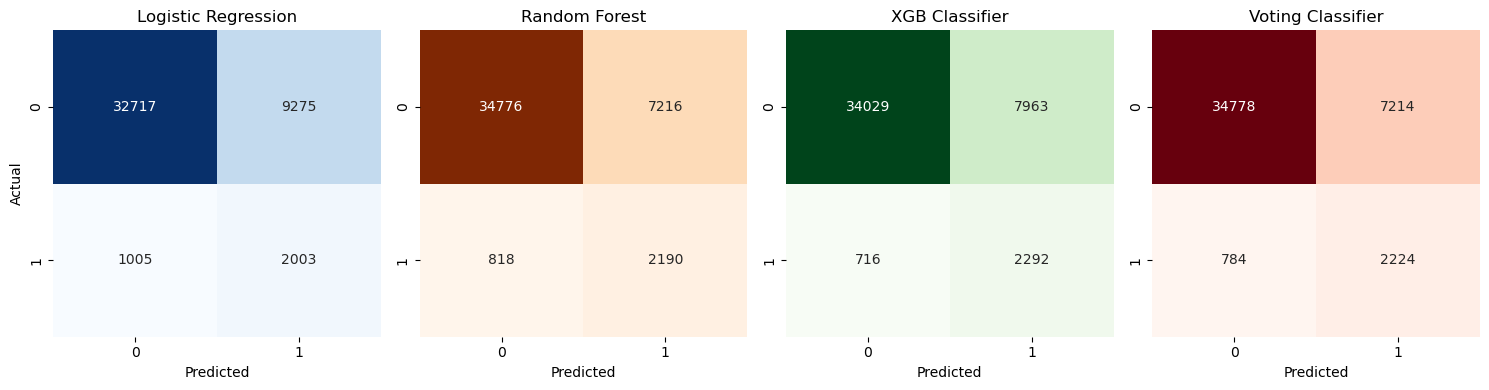

In [28]:
plt.figure(figsize=(15, 4))

# Logistic Regression
plt.subplot(1, 4, 1)
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Random Forest
plt.subplot(1, 4, 2)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title('Random Forest')
plt.xlabel('Predicted')
plt.ylabel('')

# XGB
plt.subplot(1, 4, 3)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('XGB Classifier')
plt.xlabel('Predicted')
plt.ylabel('')

# Voting
plt.subplot(1, 4, 4)
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title('Voting Classifier')
plt.xlabel('Predicted')
plt.ylabel('')

plt.tight_layout()
plt.show()

## Plotting ROC curve

In [29]:
fpr_log, tpr_log, thresholds = metrics.roc_curve(y_test, log_pred)
fpr_rf,  tpr_rf,  thresholds = metrics.roc_curve(y_test, rf_pred)
fpr_xgb, tpr_xgb, thresholds = metrics.roc_curve(y_test, xgb_pred)
fpr_voting, tpr_voting, thresholds = metrics.roc_curve(y_test, voting_pred)

In [30]:
auc_log = metrics.auc(fpr_log, tpr_log)
auc_rf  = metrics.auc(fpr_rf, tpr_rf)
auc_xgb = metrics.auc(fpr_xgb, tpr_xgb)
auc_voting = metrics.auc(fpr_voting, tpr_voting)

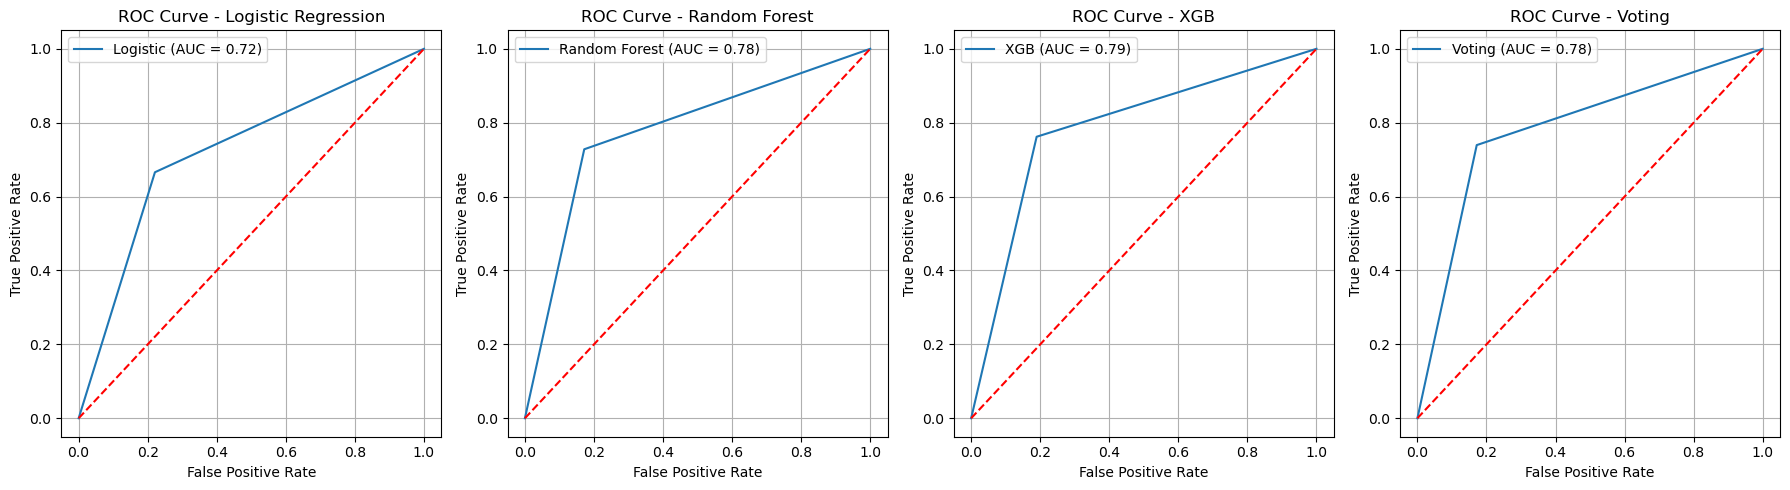

In [31]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# Logistic Regression ROC
axes[0].plot(fpr_log, tpr_log, label=f'Logistic (AUC = {auc_log:.2f})')
axes[0].plot([0, 1], [0, 1], linestyle='--', color='red')  # Diagonal line
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - Logistic Regression')
axes[0].legend()
axes[0].grid(True)

# Random Forest ROC
axes[1].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
axes[1].plot([0, 1], [0, 1], linestyle='--', color='red')  # Diagonal line
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - Random Forest')
axes[1].legend()
axes[1].grid(True)

# XGB ROC
axes[2].plot(fpr_xgb, tpr_xgb, label=f'XGB (AUC = {auc_xgb:.2f})')
axes[2].plot([0, 1], [0, 1], linestyle='--', color='red')  # Diagonal line
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('ROC Curve - XGB')
axes[2].legend()
axes[2].grid(True)

# Voting ROC
axes[3].plot(fpr_voting, tpr_voting, label=f'Voting (AUC = {auc_voting:.2f})')
axes[3].plot([0, 1], [0, 1], linestyle='--', color='red')  # Diagonal line
axes[3].set_xlabel('False Positive Rate')
axes[3].set_ylabel('True Positive Rate')
axes[3].set_title('ROC Curve - Voting')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()

## Plotting precision, recall, and F1 score

In [32]:
metrics = {
    'Logistic Regression': {
        'Precision': precision_score(y_test, log_pred, average='macro'),
        'Recall': recall_score(y_test, log_pred, average='macro'),
        'F1-Score': f1_score(y_test, log_pred, average='macro')},
    
    'Random Forest': {
        'Precision': precision_score(y_test, rf_pred, average='macro'),
        'Recall': recall_score(y_test, rf_pred, average='macro'),
        'F1-Score': f1_score(y_test, rf_pred, average='macro')},
    
    'XGB': {
        'Precision': precision_score(y_test, xgb_pred, average='macro'),
        'Recall': recall_score(y_test, xgb_pred, average='macro'),
        'F1-Score': f1_score(y_test, xgb_pred, average='macro')},

    'Voting': {
        'Precision': precision_score(y_test, voting_pred, average='macro'),
        'Recall': recall_score(y_test, voting_pred, average='macro'),
        'F1-Score': f1_score(y_test, voting_pred, average='macro')}}

In [33]:
metrics_df = pd.DataFrame(metrics).T  # transpose for plotting
metrics_df.reset_index(inplace=True)
metrics_df.rename(columns={'index': 'Model'}, inplace=True)
metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

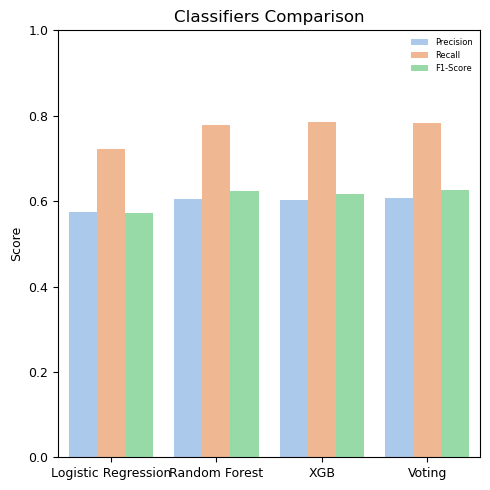

In [34]:
plt.figure(figsize=(5, 5))
sns.barplot(data=metrics_melted, x='Model', y='Score', hue='Metric', palette=sns.color_palette("pastel", n_colors=3))
plt.title('Classifiers Comparison', fontsize=12)
plt.ylim(0, 1)
plt.ylabel('Score', fontsize=9)
plt.xlabel('')
plt.legend(loc='upper right', frameon=False, fontsize=6)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()